In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# Machine learning models and tools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# This is from a different library
from xgboost import XGBRegressor    

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
# Create a dataframe of the csv file
data = pd.read_csv("final_dataset.csv")

In [ ]:
x = data[["price","overall rating","sentiment","salary"]]
y = data["number sold"]

print("x shape:", x.shape)

x shape: (5147, 5)


In [4]:
# Another data split for the x data with no added polynomial features (this is for the tree based models)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [5]:
LR = LinearRegression()
RFR = RandomForestRegressor()
XGB = XGBRegressor()

TRAINING THE MACHINE LEARNING MODELS

In [6]:
# 1. Linear Regression
LR.fit(x_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [7]:
# 2. Random Forest Regressora
RFR.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# 3. XGBoost Regressor
XGB.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
# PREDICTIONS
pred_lr  = LR.predict(x_test)
pred_rf  = RFR.predict(x_test)
pred_xgb = XGB.predict(x_test)

# EVALUATION
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2 ): {r2}")
    print("\n")

evaluate_model(y_test, pred_lr, "Linear Regression")
evaluate_model(y_test, pred_rf, "Random Forest Regressor")
evaluate_model(y_test, pred_xgb, "XGBoost Regressor")

Evaluation Metrics for Linear Regression:
Mean Absolute Error (MAE): 6734.051148472391
Mean Squared Error (MSE): 231158447.10872537
R-squared (R2 ): 0.1666456434620066


Evaluation Metrics for Random Forest Regressor:
Mean Absolute Error (MAE): 356.72562832047646
Mean Squared Error (MSE): 2260225.600491951
R-squared (R2 ): 0.9918516114185404


Evaluation Metrics for XGBoost Regressor:
Mean Absolute Error (MAE): 498.3097839355469
Mean Squared Error (MSE): 2995919.75
R-squared (R2 ): 0.9891993403434753




C:\Users\Barri\AppData\Local\Temp\ipykernel_20428\1081100208.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


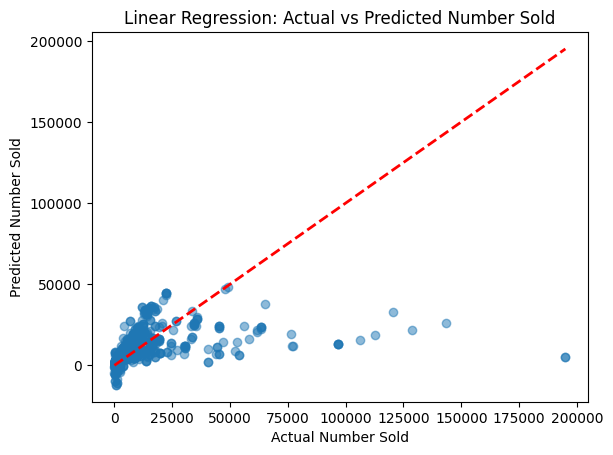

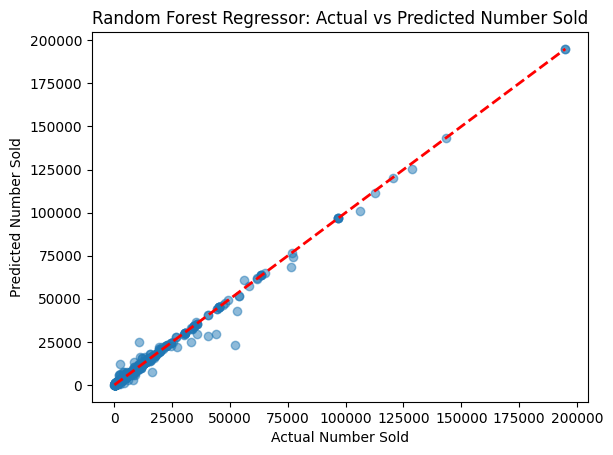

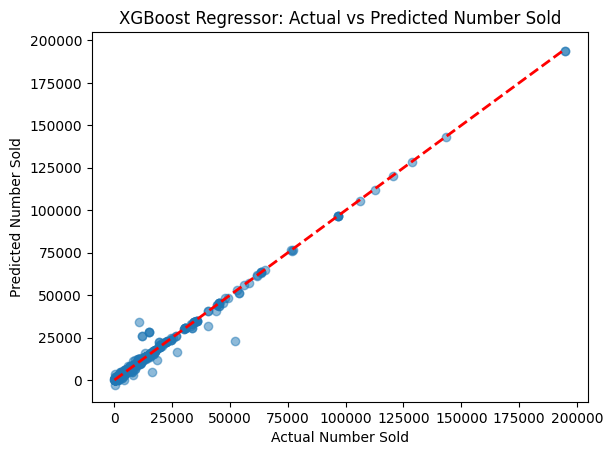

In [11]:
# Actual prediction vs predicted plot for the best model
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Number Sold")
    plt.ylabel("Predicted Number Sold")
    plt.title(f"{model_name}: Actual vs Predicted Number Sold")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
    plt.show()

plot_actual_vs_predicted(y_test, pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, pred_rf, "Random Forest Regressor")
plot_actual_vs_predicted(y_test, pred_xgb, "XGBoost Regressor")

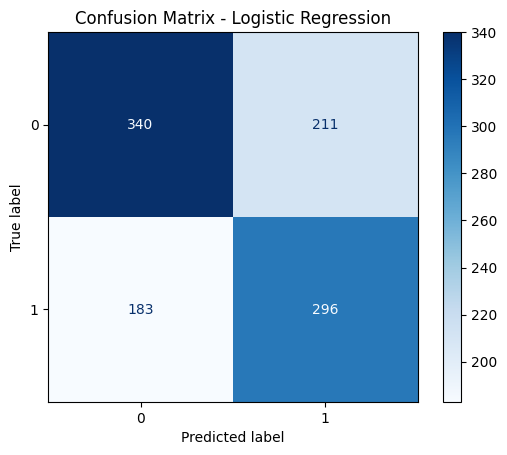

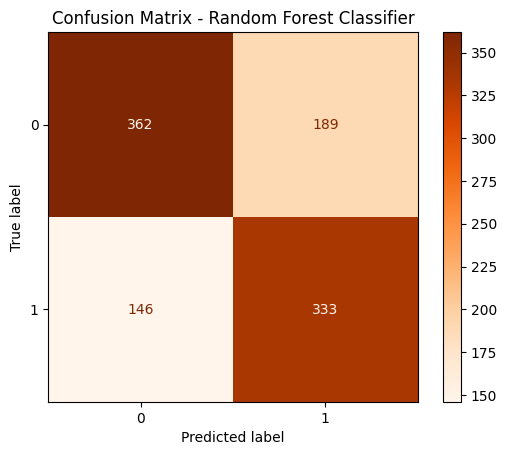

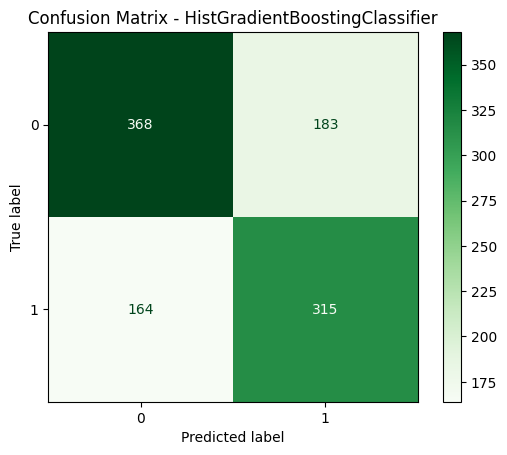

In [149]:
# CONFUSION MATRIX
# Logistic Regression confusion matrix
ConfusionMatrixDisplay.from_estimator(LR, scaler.transform(x_test), y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Random Forest Classifier confusion matrix
ConfusionMatrixDisplay.from_estimator(RF, x_test, y_test, cmap='Oranges')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# HistGradientBoostingClassifier confusion matrix
ConfusionMatrixDisplay.from_estimator(HGB, x_test, y_test, cmap='Greens')
plt.title("Confusion Matrix - HistGradientBoostingClassifier")
plt.show()

TUNING OUR BEST PERFORMING MACHINE LEARNING MODEL: Random Forest Classifier
(with a max accuracy score of 0.7029126213592233)

In [150]:
# Find the baseline accuracy of the Random Forest Classifier
rf_baseline = RandomForestClassifier(random_state=432)
rf_baseline.fit(x_train, y_train)

y_pred = rf_baseline.predict(x_test)
print("Random Forest Classifier Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Classifier Baseline Accuracy: 0.6650485436893204
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       551
           1       0.63      0.70      0.66       479

    accuracy                           0.67      1030
   macro avg       0.67      0.67      0.66      1030
weighted avg       0.67      0.67      0.67      1030



In [151]:
# Use randomized search CV to tune the Random Forest Classifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RF,
    param_distributions=param_grid,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(x_train, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best CV Accuracy:", rf_random.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best CV Accuracy: 0.6803510127523034


In [152]:
rf_best = rf_random.best_estimator_
test_pred = rf_best.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

Test Accuracy: 0.6766990291262136


Although we already tuned this to the best settings, it is still not a good model accuracy, therefore we could see that we are still lacking with the features. Now it's time to add more features such as categorical features or even the 'customer review' (the comment from the customer in text form of that particular product). 

We proceed with vectorizing the text file to become numerical. Let's use OneHotEncoder for our categorical features, and using TF-IDF vectorizer for the customer review text (Interesting Note: Since tokopedia comments are in the Indonesian language we use the libarary Sastrawi in order to get the indonesian stop words to then be used by TF-IDF)! 

In [153]:
# Use this libary for combing the numerical features with the categorical features
from sklearn.compose import ColumnTransformer

# This one is for the categorical features = [category, region]
from sklearn.preprocessing import OneHotEncoder

# This one is for the purely text feature (all suppose to be unique text data) = customer review
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Get the indonesian stop words
stop_words_ind = StopWordRemoverFactory().get_stop_words()

from sklearn.pipeline import Pipeline

In [154]:
numerical_features = ["price", "overall rating", "number sold", "total review", "salary"]
categorical_features = ["category", "region"] 
text_features = "customer review"

In [155]:
X = data[numerical_features + categorical_features + [text_features]]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=5000,
            stop_words=stop_words_ind,
            ngram_range=(1,2),
            sublinear_tf=True
        ), text_features),
        
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        
        ("num", "passthrough", numerical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_best)
])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=432
)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Final Model with Text + Categorical Features Accuracy:",
      accuracy_score(Y_test, y_pred))

print(classification_report(Y_test, y_pred))

Final Model with Text + Categorical Features Accuracy: 0.9174757281553398
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       521
           1       0.92      0.91      0.92       509

    accuracy                           0.92      1030
   macro avg       0.92      0.92      0.92      1030
weighted avg       0.92      0.92      0.92      1030



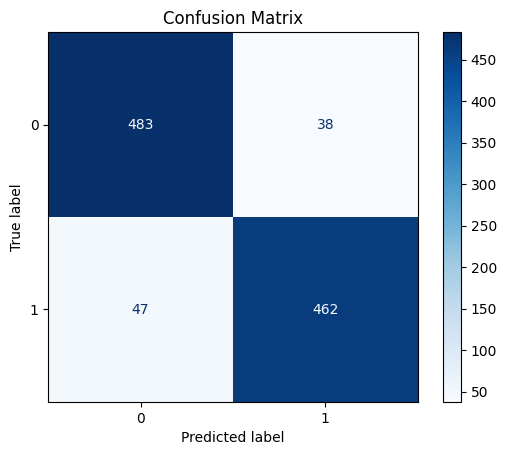

In [163]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    Y_test,
    display_labels=model.named_steps["classifier"].classes_,
    cmap="Blues",
    xticks_rotation="horizontal"
)
plt.title("Confusion Matrix")
plt.show()


In [164]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Prediction distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

Prediction distribution:
0: 530
1: 500


In [165]:
unique, counts = np.unique(Y_test, return_counts=True)
print("True label distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

True label distribution:
0: 521
1: 509
